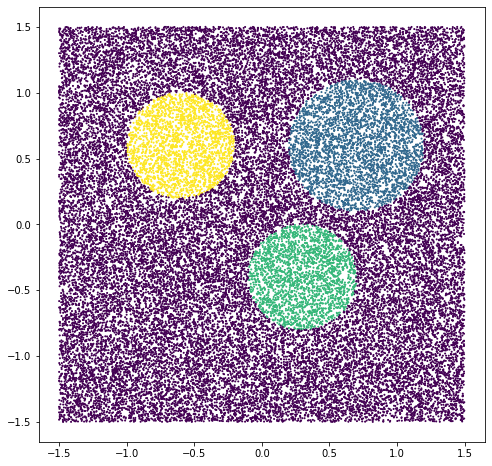

In [3]:
#Prepare data
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from tensorflow.keras.utils import to_categorical
%matplotlib inline
#Prepare data
N=40000
L=3
X = L*np.random.rand(N,2) 
X[:,0] = X[:,0]-L/2
X[:,1] = X[:,1]-L/2

Y = np.zeros(N)

for i in range(N):
    if (X[i,0]-0.7)**2+(X[i,1]-0.6)**2<0.25:
        Y[i]=1
    elif (X[i,0]-0.3)**2+(X[i,1]+0.4)**2<0.16:
        Y[i]=2
    elif (X[i,0]+0.6)**2+(X[i,1]-0.6)**2<0.16:
        Y[i]=3
    else:
        Y[i]=0
        
plt.figure(figsize=(8, 8))
plt.scatter(X[:,0], X[:, 1], s=1, c=Y)
plt.show()

data = X
labels = to_categorical(Y)

In [4]:
import activation_plot as aplt
model = aplt.prepare_model([6,6,6],n_category=len(labels[0]))
model.fit(data, labels, epochs=10,batch_size=32)

W0822 10:27:16.513668 140188594542400 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 40000 samples
Epoch 1/10
40000/40000 [==============================] - 2s 52us/sample - loss: 0.7072 - categorical_accuracy: 0.7893
Epoch 2/10
40000/40000 [==============================] - 2s 52us/sample - loss: 0.4774 - categorical_accuracy: 0.8120
Epoch 3/10
40000/40000 [==============================] - 2s 54us/sample - loss: 0.3029 - categorical_accuracy: 0.8703
Epoch 4/10
40000/40000 [==============================] - 2s 54us/sample - loss: 0.2426 - categorical_accuracy: 0.8907
Epoch 5/10
40000/40000 [==============================] - 2s 54us/sample - loss: 0.1840 - categorical_accuracy: 0.9289
Epoch 6/10
40000/40000 [==============================] - 2s 54us/sample - loss: 0.1183 - categorical_accuracy: 0.9602
Epoch 7/10
40000/40000 [==============================] - 2s 55us/sample - loss: 0.0873 - categorical_accuracy: 0.9682
Epoch 8/10
40000/40000 [==============================] - 2s 54us/sample - loss: 0.0692 - categorical_accuracy: 0.9749
Epoch 9/10
40000/40000 [=

In [5]:
from tensorflow.keras import backend as K

get_layer_output_functions = []
for layer_i in range(len(model.layers)):
    get_layer_output_functions.append(K.function(model.layers[0].input,model.layers[layer_i].output))

X_test = aplt.data_grid(200,2)
Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)
colors = aplt.get_color(X_test)

activations = aplt.get_data_activation(X_test,get_layer_output_functions)
data_activation_color = aplt.get_data_color(activations,colors)

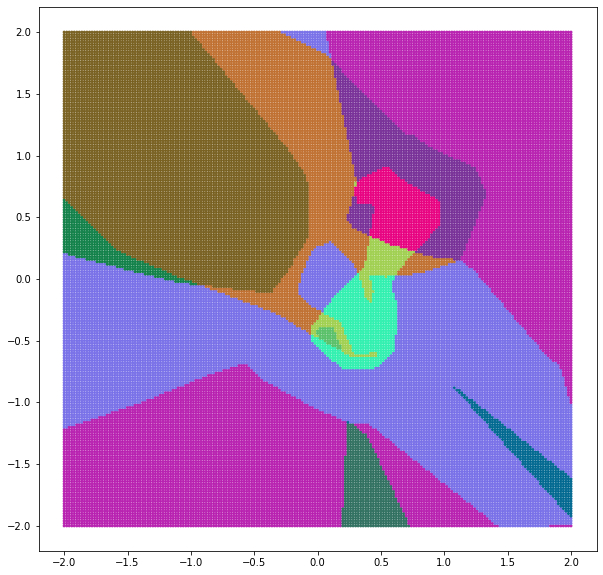

In [6]:
plt.figure(figsize=(10, 10))
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o',s=4, c=data_activation_color)
#plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=Y_test, s=1,alpha = 0.8)
plt.show()
plt.close()

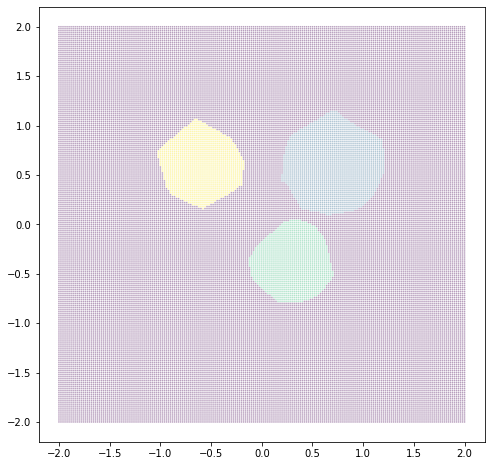

In [9]:
#test
import numpy as np

X_test = aplt.data_grid(200,2)
Y_test = model.predict(X_test)
Y_test = np.argmax(Y_test, axis=1)

plt.figure(figsize=(8, 8))
plt.scatter(X_test[:, 0], X_test[:, 1], marker='o', c=Y_test, s=0.5,alpha=0.3)
plt.show()
plt.close()